In [1]:
import vcf
import pandas as pd
import numpy as np
import matplotlib
from matplotlib_venn import venn2, venn2_circles
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import sys

In [2]:
# setup paths 
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

from src.utils.vcf import read_vcf_data, read_vcf_meta, extract_attr
from src.utils.plot import truncate_colormap, make_boxplot, plot_var_venn
from src.utils.plot import plot_nice_barplot, show_samplots_image
from src.utils.msg import print_samstats_message, get_sam_stat, print_samstats_mismatch, print_sams_pairstats
from src import config

cmap = plt.get_cmap('Blues')
cmap_tr = truncate_colormap(cmap, 0.3, 1)

## Sequencing libraries

#### SG001_1 library contains paired reads, while SG001_2 contains longer single reads

In [3]:
infile = os.path.join(config.DATA_PROCESSED_PATH, config.SAM_STAT)
stats = pd.read_csv(infile, sep="\t")
stats.loc[stats.Attribute.isin(['raw_total_sequences:'])]

print_samstats_message(stats)


Sequencing library SG001_1.bam
Paired 148.0bp reads with 249.7+/-64.5bp average insert size

Sequencing library SG001_2.bam
Single reads with 137.0bp average read length


## Sequencing errors

#### SG001_1 has lower throughput, but higher quality sequences than SG001_2
* SG001_**1** has **lower error** rate
* SG001_**1** has **higher** average read **quality**
* SG001_**2** has **more reads**

In [4]:
print_samstats_mismatch(stats)


Sequencing library SG001_1.bam
Mapped: 6152478.0bp
Mismatched: 17365.0bp
Error-rate: 0.002833427
Average read quality: 36.5
Duplicate reads: 0.0

Sequencing library SG001_2.bam
Mapped: 20288660.0bp
Mismatched: 307892.0bp
Error-rate: 0.01533555
Average read quality: 21.7
Duplicate reads: 0.0


#### Most paired end reads in SG001_1 are properly paired

In [5]:
filename='SG001_1.bam'
print_sams_pairstats(stats.loc[stats.Filename.isin([filename])])


Sequencing library SG001_1.bam
Total paired reads: 41873.0
Proper pairs: 40904.0 (98.0%)
Pairs on different chromsomes 173.0
Inward orientation: 18915.0
Outward orientation: 30.0
Other orientation: 21.0


#### Visual inspection of sequencing errors: SG001_2 is problematic
Sequencing errors were visually inspected in **IGV viewer** generated as **single page html**:
* [IGV viewer](/files/data/processed/igv_viewer.html) - **CLICK** to visualise the alignments in new tab

Visual inspection demonstrates that:
* **SG001_1** contains a few read pair mates aligned on different chromosomes, that **do not pose a challenge for variant calls**
* **SG001_2** is susceptible to a high number of short insertions and deletions that **may lead to false variant calls**


## Coverage Depth and Uniformity

#### SG001_2 generated more reads, but most did not align to the reference
* SG001_2 generated 2.6 times more reads than SG001_1
* SG001_1 has >98% of reads mapped to the reference at a lower error rate than for SG001_2
* SG001_2 has only 65% of reads mapped to the reference at a relatively high error rate

In [6]:
plot_df = dict()
for filename in stats.Filename.unique():
    plot_df[filename] = dict()
    plot_df[filename]["mapped_fraction"] = get_sam_stat(stats, filename, 'reads_mapped:')/get_sam_stat(stats, filename, 'raw_total_sequences:')
    plot_df[filename]["reads_mapped"] = get_sam_stat(stats, filename, 'reads_mapped:')
    plot_df[filename]["reads_total"] = get_sam_stat(stats, filename, 'raw_total_sequences:')
    plot_df[filename]["reads_duplicated"] = get_sam_stat(stats, filename, 'reads_duplicated:')
    plot_df[filename]["error_rate"] = get_sam_stat(stats, filename, 'error_rate:')
pd.DataFrame(plot_df).T.reset_index()

,index,mapped_fraction,reads_mapped,reads_total,reads_duplicated,error_rate
0,SG001_1.bam,0.987844,41365.0,41874.0,0.0,0.002833
1,SG001_2.bam,0.656101,107970.0,164563.0,0.0,0.015336


#### Despite much deeper coverage SG001_2 suffers from non-uniform coverage

* Visual inspection of samplots (in data/processed/samplots/), with the selected examples of target regions shown below.  
* Light gray indicates low quality read coverage (stacked).

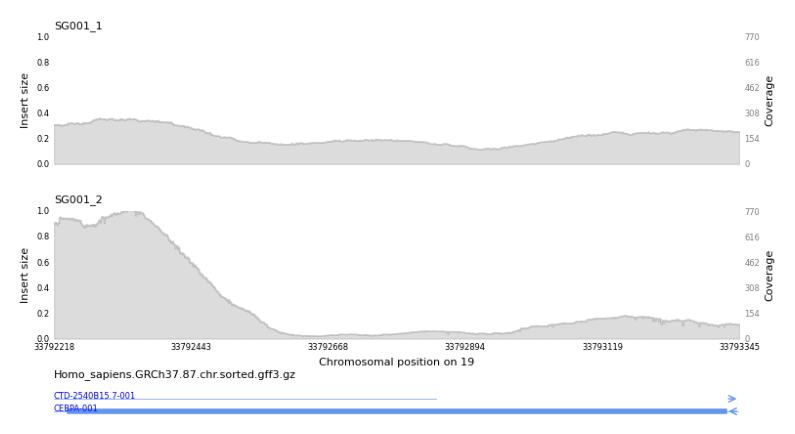

In [7]:
show_samplots_image("19:33792218-33793345.png")

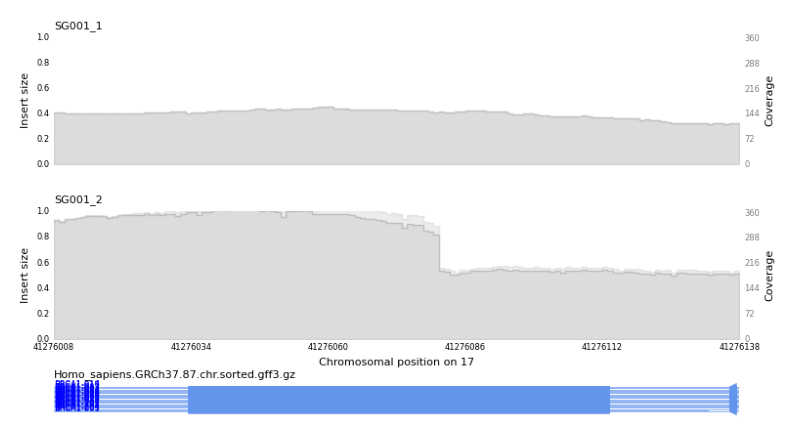

In [8]:
show_samplots_image("17:41276008-41276138.png")

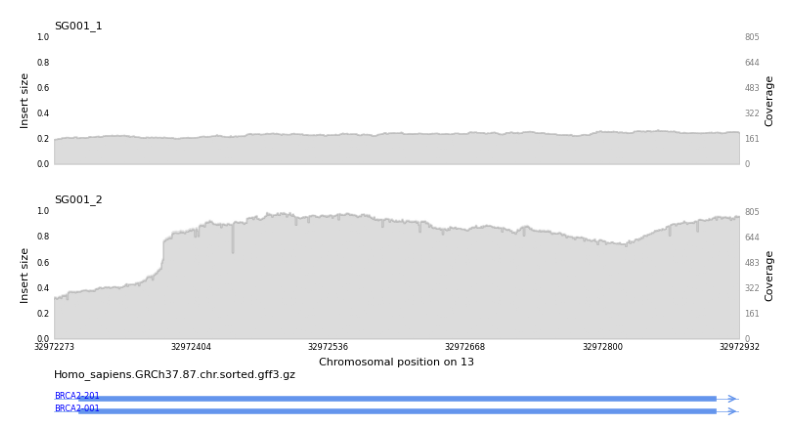

In [9]:
show_samplots_image("13:32972273-32972932.png")

## Variant analysis

#### Genes in target regions
Target regions cover genes BRCA1, BRCA2, SRSF2, CEBPA and pseudogene RPL21P4. Mutations in these genes are associated with an increased cancer risk.

In [10]:
infile = os.path.join(config.DATA_PROCESSED_PATH, config.ANNOTR_TARGET)
target_annot = pd.read_csv(infile, sep='\t', header=None)
target_annot.columns = ['chr', 'start', 'end', 'Gene', 'element','strand']
target_annot.Gene.value_counts()

BRCA2      26
BRCA1      22
SRSF2       1
CEBPA       1
RPL21P4     1
Name: Gene, dtype: int64

#### SG001_1 retrieves all variants from Golden reference that fall within target regions with only 2 false positives
* Both sequencers retrieve all 13 variants from Golden Reference
* SG001_1 has **2 False Positives**
* SG001_2 has **26 False Positives** (explained by higher sequencing error and lower quality)

,Region,Common_variants,Files
0,Target,13,"SG001_1, SG001_2, reference"
1,Reference,34,"SG001_1, SG001_2, reference"
2,Target,13,"SG001_1, reference"
3,Reference,35,"SG001_1, reference"
4,Target,13,"SG001_2, reference"
5,Reference,52,"SG001_2, reference"


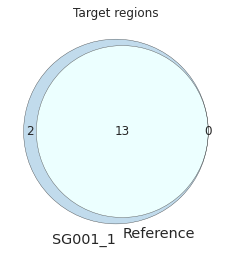

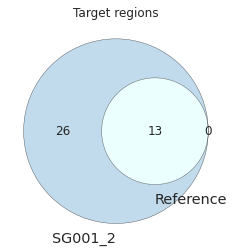

In [11]:
ref_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_REF), sep='\t')
target_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_TAR), sep='\t')
common_vars = pd.read_csv(os.path.join(config.DATA_PROCESSED_PATH, config.VARS_COMMON), sep='\t')
display(common_vars.replace({'Files':{'3': 'SG001_1, SG001_2, reference', 
                                      'SG001_1_GT.vcf.gz':'SG001_1, reference',
                                      'SG001_2_GT.vcf.gz':'SG001_2, reference'}}))

plot_var_venn("SG001_1_GT.vcf.gz", "SG001_ref.vcf.gz", target_vars, common_vars, compare_to='Target')
plot_var_venn("SG001_2_GT.vcf.gz", "SG001_ref.vcf.gz", target_vars, common_vars, compare_to='Target')

#### Considering full reference region, SG001_2 retrieves more variants than SG001_1, but more than half of these variants are False Positives 

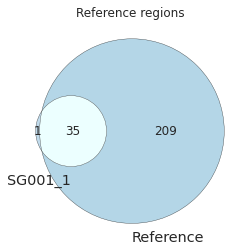

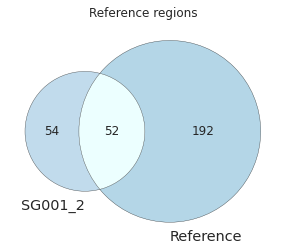

In [12]:
plot_var_venn("SG001_1_GT.vcf.gz", "SG001_ref.vcf.gz", ref_vars, common_vars, compare_to='Reference')
plot_var_venn("SG001_2_GT.vcf.gz", "SG001_ref.vcf.gz", ref_vars, common_vars, compare_to='Reference')

#### Considering all called variants in each library, SG001_1 has better mapping quality and lower background noise than SG001_2

In [13]:
var_dict = {}
info_dict= {}
filter_dict = {}

for filename in ['SG001_1_GT_target.vcf', 'SG001_2_GT_target.vcf', 'SG001_ref_target.vcf']:
    vcf_dict, samples = read_vcf_data(os.path.join(config.DATA_INTERIM_PATH, filename))
    var_dict[config.PRETTY_NAMES[filename]] = vcf_dict
    
for filename in ['SG001_1_GT.vcf.gz', 'SG001_2_GT.vcf.gz']:
    vcf_info, vcf_filters = read_vcf_meta(os.path.join(config.DATA_RAW_PATH, filename))
    info_dict[config.PRETTY_NAMES[filename]] = vcf_info
    filter_dict[config.PRETTY_NAMES[filename]] = vcf_filters

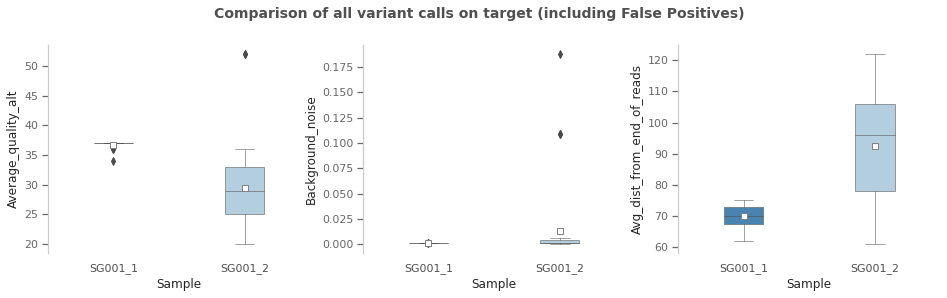

In [14]:
target_cols = ["Average_quality_alt", "Background_noise", "Avg_dist_from_end_of_reads"]

df1 = extract_attr(var_dict, info_dict, "QA", "Average_quality_alt", "SG001_1")
df2 = extract_attr(var_dict, info_dict, "QA", "Average_quality_alt", "SG001_2")
df_stats = pd.concat([df1, df2]).reset_index(drop=True)

df1 = extract_attr(var_dict, info_dict, "BGN", "Background_noise", "SG001_1")
df2 = extract_attr(var_dict, info_dict, "BGN", "Background_noise", "SG001_2")
df_merge = pd.concat([df1, df2]).reset_index(drop=True)
df_stats["Background_noise"] = df_merge["Background_noise"]

df1 = extract_attr(var_dict, info_dict, "DEA", "Avg_dist_from_end_of_reads", "SG001_1")
df2 = extract_attr(var_dict, info_dict, "DEA", "Avg_dist_from_end_of_reads", "SG001_2")
df_merge = pd.concat([df1, df2]).reset_index(drop=True)
df_stats["Avg_dist_from_end_of_reads"] = df_merge["Avg_dist_from_end_of_reads"]

for col in target_cols:
    df_stats[col] = df_stats[col].astype(float)
    
make_boxplot(df_stats, "Sample", target_cols, main_title="Comparison of all variant calls on target (including False Positives)")

#### 1 of 2 false positives in SG001_1 can be filtered out by setting more stringent quality filters
* Table below shows 3 outliers for Average quality, 1 True Positive (TP) and 2 False Positives (FP)
* Setting even more stringent quality filtering may be too conservative as may filter out 1 TP

In [15]:
df_1 = df_stats.loc[df_stats.Sample.isin(['SG001_1'])]
df_1['location'] = list(var_dict['SG001_1'].keys())
ref_positions = [k for k in list(var_dict['SG001_1'].keys()) if k in list(var_dict['Reference'].keys())]
df_1['Status'] = 'FP'
df_1.loc[df_1.location.isin(ref_positions),'Status'] = 'TP'
display(df_1.sort_values('Average_quality_alt').head(3))

,Average_quality_alt,Sample,Background_noise,Avg_dist_from_end_of_reads,location,Status
14,34.0,SG001_1,0.001323,68.0,19:33792631,FP
0,36.0,SG001_1,0.001110,69.0,13:32911888,TP
13,36.0,SG001_1,0.001110,74.0,17:74733099,FP


## Conclusion: SG001_1 is better sequencing library 
* Better quality reads
* Lower error rate
* Uniform coverage
* Few false positives

**Further impovements**  
* False positives can be tackled through an improved 
* Overall, it is recommended to rely on the latest human genome reference release

In [16]:
samples

['FAKESAMPLE']